# Intuitive explanation of least-squares estimation of vector autoregerssion

Are you one of those who have seen the least-squares estimator $\hat{\beta} = (X´X)^{-1} X´Y$ a thousand times but neven really fully understood what it means? Or matrix dimensions of VAR equations give you a headache?

You've come to the right place! In this notebook we build a solid intuitive understanding what it means to estimate a vector-autoregresson (VAR) model using least-squares. 

Notebok by @VilleEcon.

NOTEBOOK INCOMPLETE!

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
pd.options.display.max_rows = 6
np.random.seed(seed=1337)

Let $\{y_{i, t} \}_{t=0}^T$ denote a one-dimensional time series. A collection of N time series $\{y_{1, t}, ... , y_{N, t} \}_{t=0}^T$ can be written as $y_t$, $t=0,...,T$. Each $y_t$ is thus a $1xN$ vector. Let's generate sampe data $y_t$ over $t=0,...,300$ for two variables:

First and last observations from simulated sample data look like this:


,y1,y2
time,,
0,4.138730,2.262281
1,3.543315,3.492077
2,2.734186,1.990307
...,...,...
297,6.668725,2.668351
298,6.702933,2.681498
299,6.407219,2.461158


And here are the full time series over t=0,...,300:


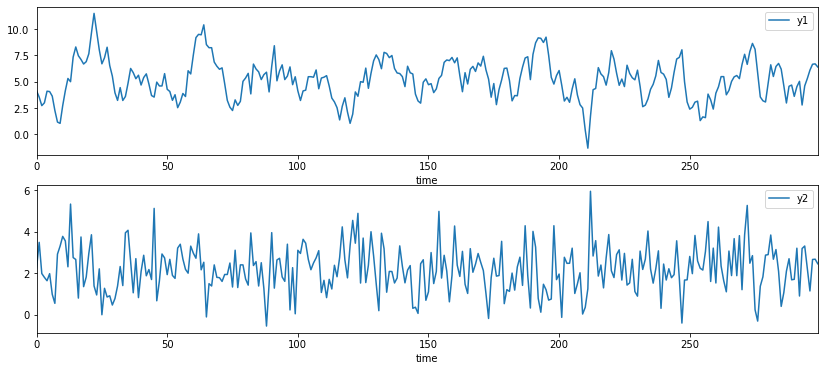

In [2]:
# Model parameters
N = 2
T = 300
intercepts = np.array([0, 3])
coefs = np.array([
       [0.8, 0.5], 
       [-0.2, 0.1],
]).flatten(order="C")
corr = np.array([
    [1, 0.2],
    [0.2, 1],
])
stds = [1, 1]
endog = np.array([[ None,  None]])

# VAR model object
mod1 = sm.tsa.VARMAX(endog, order=(1, 0))

# Transform corerlation to covariance
cov = corr2cov(corr, stds)

# Simulate data
params = np.concatenate([intercepts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0)
df = pd.DataFrame(mod1.simulate(params, T), columns=["y1", "y2"])
df.index.name = "time"

# Display data
print("First and last observations from simulated sample data look like this:")
display(df)
print("And here are the full time series over t=0,...,{}:".format(T))
fig = plt.figure(figsize=(14, 6))
for idx, col in enumerate(df.columns):
    ax = fig.add_subplot(len(df.columns), 1, idx+1)
    df[[col]].plot(ax=ax)

Variables $y_t, y_{t-1}, ..., y_{t-p}$ for given $t$ (say $t=25$) and e.g. $p=2$ look like

In [3]:
crt_time = 25
display(df.iloc[[crt_time]])
display(df.iloc[[crt_time-1]])
display(df.iloc[[crt_time-2]])

,y1,y2
time,,
25,6.707518,0.007434


,y1,y2
time,,
24,8.037696,2.216264


,y1,y2
time,,
23,9.763864,0.960621


A $VAR(p)$ model reads

$$
\begin{align*}
y_{t}' & = \beta_1 y_{t-1}' + \cdots + \beta_{p} y_{t-p}' + u_{t} \quad , \ t=p, ... , T,
\end{align*}
$$

where $'$ denotes transpose, $\beta_i$ are $NxN$ parameter matrices and $u_t$ is a $Nx1$ vector of errors. This means that for $t=25$ the VAR equation would look like

$$
\begin{align*}
\begin{bmatrix} 6.70 \\ 0.01 \end{bmatrix} & = \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} \begin{bmatrix} 8.04 \\ 2.22 \end{bmatrix} + \begin{bmatrix} \beta_{2,11} & \beta_{2,12} \\ \beta_{2,21} & \beta_{2,22} \end{bmatrix} \begin{bmatrix} 9.76 \\ 0.96 \end{bmatrix} + \begin{bmatrix} u_{25, 1}\\ u_{25, 2} \end{bmatrix}
\end{align*}
$$



Now for each $t$ define a $Np \times 1$ vector

$$z_t \equiv \begin{bmatrix} y_t & y_{t-1} & \cdots & y_{t-p+1} \end{bmatrix}$$

How does $z_t$ look like? For example for $t=25$ and $p=2$:

In [44]:
z_25 = pd.DataFrame(df.loc[23:25].sort_index(ascending=False).values.flatten(order="C")).T
z_25.columns = ["y_25_1", "y_25_2", "y_24_1", "y_24_2", "y_23_1", "y_23_2"]
z_25

,y_25_1,y_25_2,y_24_1,y_24_2,y_23_1,y_23_2
0,6.707518,0.007434,8.037696,2.216264,9.763864,0.960621


## HERE BELOW WHAT I THINK IS STILL WRONG!

To facilitate estimation of VAR equation over all time periods, we introduce $TxN$ matrix $Y_\tau$ that stacks observations over time into a single matrix. Notice here the use of $\tau$ as time subscript instead of $t$; we want to explicitly distinguish time series index $t=1,...,T$ from *time alignment index* $\tau$. The difference will soon become appararent.

$Y_\tau$ looks like this:

In [4]:
pd.DataFrame(df.values, columns=["y1_tau", "y2_tau"])

,y1_tau,y2_tau
0,4.138730,2.262281
1,3.543315,3.492077
2,2.734186,1.990307
...,...,...
297,6.668725,2.668351
298,6.702933,2.681498
299,6.407219,2.461158


But what would $Y_{\tau-1}$ then look like? Well, very much the same actually:

In [5]:
pd.DataFrame(df.shift(1).values, columns=["y1_tau", "y2_tau"])

,y1_tau,y2_tau
0,NaN,NaN
1,4.138730,2.262281
2,3.543315,3.492077
...,...,...
297,6.105079,1.152066
298,6.668725,2.668351
299,6.702933,2.681498


But wait a minute: how come are the first row observations of the matrix now NaN? $Y_{\tau-1}$ is nothing else but a **lagged** version (by one time period) of $Y_\tau$. The trick is that in order to use these two matrices in same AR equation later we need to **align** the two matrices by their time indices. Thus if we were to look at e.g. concatenated $T \times 4N$ matrix $[Y_\tau \ \ Y_{\tau-1} \ \ Y_{\tau-2} \ \ Y_{\tau-3}]$ it would look like this:

In [6]:
pd.DataFrame(
    data=pd.concat([df, df.shift(1), df.shift(2), df.shift(3)], axis=1).values,
    columns=["y1_tau", "y2_tau", "y1_tau-1", "y2_tau-1", "y1_tau-2", "y2_tau-2", "y1_tau-3", "y2_tau-3"]
)

,y1_tau,y2_tau,y1_tau-1,y2_tau-1,y1_tau-2,y2_tau-2,y1_tau-3,y2_tau-3
0,4.138730,2.262281,NaN,NaN,NaN,NaN,NaN,NaN
1,3.543315,3.492077,4.138730,2.262281,NaN,NaN,NaN,NaN
2,2.734186,1.990307,3.543315,3.492077,4.138730,2.262281,NaN,NaN
...,...,...,...,...,...,...,...,...
297,6.668725,2.668351,6.105079,1.152066,5.310023,2.242922,4.609885,3.315259
298,6.702933,2.681498,6.668725,2.668351,6.105079,1.152066,5.310023,2.242922
299,6.407219,2.461158,6.702933,2.681498,6.668725,2.668351,6.105079,1.152066


Dropping rows with NaN values we obtain a $(T-3) \times 4N$ matrix:

In [7]:
df_concat = pd.DataFrame(
    data=pd.concat([df.copy(), df.copy().shift(1), df.copy().shift(2), df.copy().shift(3)], axis=1).dropna().values,
    columns=["y1_tau", "y2_tau", "y1_tau-1", "y2_tau-1", "y1_tau-2", "y2_tau-2", "y1_tau-3", "y2_tau-3"],
    index=range(3,T)
)
df_concat

,y1_tau,y2_tau,y1_tau-1,y2_tau-1,y1_tau-2,y2_tau-2,y1_tau-3,y2_tau-3
3,3.003597,1.806434,2.734186,1.990307,3.543315,3.492077,4.138730,2.262281
4,4.105860,1.643830,3.003597,1.806434,2.734186,1.990307,3.543315,3.492077
5,4.071604,1.984575,4.105860,1.643830,3.003597,1.806434,2.734186,1.990307
...,...,...,...,...,...,...,...,...
297,6.668725,2.668351,6.105079,1.152066,5.310023,2.242922,4.609885,3.315259
298,6.702933,2.681498,6.668725,2.668351,6.105079,1.152066,5.310023,2.242922
299,6.407219,2.461158,6.702933,2.681498,6.668725,2.668351,6.105079,1.152066


For further examples we will work with the aligned, common time sample so that we define $\tilde{T} \equiv T-p-1$. In our example above, $\tilde{T} \equiv T-3$. Why $T-3$ and not $T-2$? Valid question, which will be answered below when we talk about companion form of the VAR equation.

But first, we write the VAR(p) equation as

$$
\begin{align*}
Y_{\tau} & = Y_{\tau-1} \beta_1 + \cdots + Y_{\tau-p} \beta_{p} + U_{\tau} \quad , \ \tau=p, ... , T,
\end{align*}
$$

where $Y_{\tau-j}$, $j=0,...,p$ are $\tilde{T} \times N$, $\beta_i$, $i=1,2$ are $N \times N$ and $U_t$ is $\tilde{T} \times N$ matrix.

In our example case with $N=2$ and $p=2$ and sampled data, the equation would look like

$$
\begin{align*}
\begin{bmatrix} 3.00 & 1.81 \\ \cdots & \cdots \\ 6.41 & 2.46 \end{bmatrix} & = \begin{bmatrix} 2.73 & 1.99 \\ \cdots & \cdots \\ 6.70 & 2.68 \end{bmatrix} \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} + \begin{bmatrix} 3.54 & 3.49 \\ \cdots & \cdots \\ 6.67 & 2.67 \end{bmatrix} \begin{bmatrix} \beta_{2,11} & \beta_{2,12} \\ \beta_{2,21} & \beta_{2,22} \end{bmatrix} + \begin{bmatrix} U_{1,1} & U_{1,2} \\ \cdots & \cdots \\ U_{2,1} & U_{2,2} \end{bmatrix}
\end{align*}
$$

We are still not quite done. VAR is estimated from its so-called *companion form*. We will arrive at companion form when we define

$$Z_\tau \equiv \begin{bmatrix} Y_{\tau} \\ Y_{\tau-1} \\ Y_{\tau-2} \\ \vdots \\ Y_{\tau-p+1} \end{bmatrix} \ , \quad \Gamma \equiv \begin{bmatrix} \beta_1 & \beta_2 & \cdots & \beta_p \\ I & 0 & \cdots & 0 \\ 0 & I & \cdots & 0 \\ \vdots & \vdots & \vdots & \vdots \\ 0 & 0 & I & 0 \end{bmatrix} \ , \quad W_\tau \equiv \begin{bmatrix} U_\tau \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$$

where $Z_\tau$ and $W_\tau$ are $p\tilde{T} \times N$ matrices, $\Gamma$ is a $Np \times Np$ matrix.

$Z_\tau$ with $p=2$ looks like this (with selected indices from start and end of each $Y_\tau$, $Y_{\tau-1}$, and $Y_{\tau-2}$):

In [21]:
Z_tau = pd.DataFrame(
    data=np.concatenate([df_concat[["y1_tau", "y2_tau"]].values, df_concat[["y1_tau-1", "y2_tau-1"]].values, df_concat[["y1_tau-2", "y2_tau-2"]].values], axis=0),
    index=df_concat.index.to_list()*3,
    columns=["y1", "y2"]
)
pd.options.display.max_rows = 12
display(Z_tau.iloc[[0, 1, 295, 296, 297, 298, 592, 593, 594, 595, 889, 890]])
pd.options.display.max_rows = 6

,y1,y2
3,3.003597,1.806434
4,4.105860,1.643830
298,6.702933,2.681498
299,6.407219,2.461158
3,2.734186,1.990307
4,3.003597,1.806434
298,6.668725,2.668351
299,6.702933,2.681498
3,3.543315,3.492077
4,2.734186,1.990307


What does $Z_{\tau-1}$ look like? Glad you asked!

In [22]:
Z_tau_m1 = pd.DataFrame(
    data=np.concatenate([df_concat[["y1_tau-1", "y2_tau-1"]].values, df_concat[["y1_tau-2", "y2_tau-2"]].values, df_concat[["y1_tau-3", "y2_tau-3"]].values], axis=0),
    index=df_concat.index.to_list()*3,
    columns=["y1", "y2"]
)
pd.options.display.max_rows = 12
display(Z_tau_m1.iloc[[0, 1, 295, 296, 297, 298, 592, 593, 594, 595, 889, 890]])
pd.options.display.max_rows = 6

,y1,y2
3,2.734186,1.990307
4,3.003597,1.806434
298,6.668725,2.668351
299,6.702933,2.681498
3,3.543315,3.492077
4,2.734186,1.990307
298,6.105079,1.152066
299,6.668725,2.668351
3,4.138730,2.262281
4,3.543315,3.492077


Now we also see why we retained an "extra" lag above in $\tilde{T} \equiv T-3$; without the third lag we would not had $Y_{\tau-3}$ (which we need for $Z_{\tau-1}$) in the aligned dataset.

in summary, if we were to look at concatenated $3\tilde{T} \times 2N$ matrix $[Z_\tau \ \ Z_{\tau-1}]$ it would look like this:

In [23]:
pd.options.display.max_rows = 12
display(pd.DataFrame(
    data=pd.concat([Z_tau, Z_tau_m1], axis=1).values,
    columns=["z1_tau", "z2_tau", "z1_tau-1", "z2_tau-1"],
    index=Z_tau.index
).iloc[[0, 1, 295, 296, 297, 298, 592, 593, 594, 595, 889, 890]])
pd.options.display.max_rows = 6

,z1_tau,z2_tau,z1_tau-1,z2_tau-1
3,3.003597,1.806434,2.734186,1.990307
4,4.105860,1.643830,3.003597,1.806434
298,6.702933,2.681498,6.668725,2.668351
299,6.407219,2.461158,6.702933,2.681498
3,2.734186,1.990307,3.543315,3.492077
4,3.003597,1.806434,2.734186,1.990307
298,6.668725,2.668351,6.105079,1.152066
299,6.702933,2.681498,6.668725,2.668351
3,3.543315,3.492077,4.138730,2.262281
4,2.734186,1.990307,3.543315,3.492077


Again we define newly aligned time sample wtih $\hat{T} \equiv \tilde{T}-1$.

Now we can write the VAR(p) equation in its companion form, that is as VAR(1):

$$
\begin{align*}
Z_{\tau} = \Gamma Z_{\tau-1} + W_\tau
\end{align*}
$$

In our example case with $N=2$ and $p=2$ and sampled data, the equation would look like





$$
\begin{bmatrix} 3.00 & 1.81 \\ \vdots & \vdots \\ 6.41 & 2.46 \\ 2.73 & 1.99 \\ \vdots & \vdots \\ 6.70 & 2.68 \\ 3.54 & 3.49 \\ \vdots & \vdots \\ 6.69 & 2.67 \end{bmatrix} =

\begin{bmatrix} \beta_1 & \beta_2 & \cdots & \beta_p \\ I & 0 & \cdots & 0 \\ 0 & I & \cdots & 0 \\ \vdots & \vdots & \vdots & \vdots \\ 0 & 0 & I & 0 \end{bmatrix}
\begin{bmatrix} 2.73 & 1.99 \\ \vdots & \vdots \\ 6.70 & 2.68 \\ 3.54 & 3.49 \\ \vdots & \vdots \\ 6.68 & 2.67 \\ 4.14 & 2.26 \\ \vdots & \vdots \\ 6.11 & 1.15 \end{bmatrix} \

 + \begin{bmatrix} U_\tau \\ \vdots \\ 0 \\ 0 \\ \vdots \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
 $$

$$
\begin{bmatrix} \beta_{1, 11} & \beta_{1, 12} & \beta_{2, 11} & \beta_{2, 12} \\ \beta_{1, 21} & \beta_{1, 22} & \beta_{2, 21} & \beta_{2, 22} \\ 1 & 1 & 0 & 0 \\ 1 & 1 & 0 & 0 \\ 0 & 0 & I & 0 \\ 0 & 0 & I & 0 \\ \vdots & \vdots & \vdots & \vdots \end{bmatrix}
$$